# Plot clade connectivity between timepoints

To ensure that clades are connected between timepoints, enabling model fitting across timepoints for all clades, plot the first timepoint each clade occurs in a network and connect adjacent clades with edges based on traversal of the tips-to-clades map for all timepoints.

In [81]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

plt.style.use("huddlej")

In [82]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [83]:
tips = pd.read_csv("../results/builds/h3n2/5_viruses_per_month/sample_0/2000-10-01--2015-10-01/standardized_tip_attributes.tsv",
                   sep="\t", parse_dates=["timepoint"])
tips = tips.loc[
    tips["segment"] == "ha",
    ["strain", "clade_membership", "timepoint", "frequency"]
].copy()

In [84]:
valid_tips = tips.strain.unique()

In [85]:
valid_tips.shape

(1835,)

In [86]:
data_path = "../results/builds/h3n2/5_viruses_per_month/sample_0/2000-10-01--2015-10-01/tips_to_clades.tsv"

In [87]:
df = pd.read_csv(data_path, sep="\t", parse_dates=["timepoint"])

In [88]:
df.shape

(460301, 6)

In [89]:
df.head()

,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Canterbury/103/2000,2c59b06,1,h3n2,ha,2004-10-01
1,A/Canterbury/103/2000,4faf0ed,2,h3n2,ha,2004-10-01
2,A/Canterbury/103/2000,root,3,h3n2,ha,2004-10-01
3,A/HongKong/762/2001,4ec8fe6,1,h3n2,ha,2004-10-01
4,A/HongKong/762/2001,2c59b06,2,h3n2,ha,2004-10-01


In [90]:
df["tip"].isin(valid_tips).sum()

410932

In [91]:
df = df[df["tip"].isin(valid_tips)].copy()

In [92]:
df = tips.merge(df, left_on="strain", right_on="tip", suffixes=["_tip", ""]).copy()

In [93]:
sorted_df = df.sort_values(["timepoint", "tip", "depth"]).copy()

In [94]:
sorted_df.head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Aichi/181/2004,e5a7ac4,2004-10-01,0.005842,A/Aichi/181/2004,e5a7ac4,1,h3n2,ha,2004-10-01
255,A/Aichi/181/2004,e5a7ac4,2005-04-01,0.000001,A/Aichi/181/2004,e5a7ac4,1,h3n2,ha,2004-10-01
1,A/Aichi/181/2004,e5a7ac4,2004-10-01,0.005842,A/Aichi/181/2004,66684e0,10,h3n2,ha,2004-10-01
256,A/Aichi/181/2004,e5a7ac4,2005-04-01,0.000001,A/Aichi/181/2004,66684e0,10,h3n2,ha,2004-10-01
2,A/Aichi/181/2004,e5a7ac4,2004-10-01,0.005842,A/Aichi/181/2004,dffb0cc,11,h3n2,ha,2004-10-01


In [95]:
sorted_df["clade_membership"].unique().shape

(521,)

In [96]:
timepoint_by_clade_name = sorted_df.groupby("clade_membership")["timepoint_tip"].min().to_dict()
timepoint_by_clade_name["root"] = df["timepoint"].min() - pd.DateOffset(months=6)

In [97]:
clade_id_by_name = {"root": 20}
clade_counter_by_timepoint = defaultdict(int)

for clade, timepoint in timepoint_by_clade_name.items():
    clade_id_by_name[clade] = clade_counter_by_timepoint[timepoint]
    clade_counter_by_timepoint[timepoint] += 5

Create a graph that will connect all adjacent clades (essentially the original tree) and note the first timepoint each clade was observed.

In [98]:
tree = nx.Graph()

#timepoint_by_clade_name = {"root": df["timepoint"].min() - pd.DateOffset(months=6)}
observed_tips = set()

for timepoint, timepoint_df in sorted_df.groupby("timepoint"):
    print(timepoint)
    for tip, tip_df in timepoint_df.groupby("tip"):
        # Only consider the clade linkages for tips once when that tip is first observed.
        if tip in observed_tips:
            continue
        
        observed_tips.add(tip)
        clades = tip_df["clade_membership"].values
        
        # Loop through clades, adding edges between adjacent clades.
        for i in range(len(clades)):
            # Make sure each clade is represented in the tree.
            tree.add_node(clades[i])

            # Link each clade after the first one back to its relative.
            if i > 0:
                tree.add_edge(clades[i], clades[i - 1])

            # Note the first timepoint each clade was observed.
            #if clades[i] not in timepoint_by_clade_name:
            #    timepoint_by_clade_name[clades[i]] = tip_timepoint
            #    clade_id_by_name[clades[i]] = clade_counter_by_timepoint[tip_timepoint]
            #    clade_counter_by_timepoint[tip_timepoint] += 5

2004-10-01 00:00:00
2005-04-01 00:00:00
2005-10-01 00:00:00
2006-04-01 00:00:00
2006-10-01 00:00:00
2007-04-01 00:00:00
2007-10-01 00:00:00
2008-04-01 00:00:00
2008-10-01 00:00:00
2009-04-01 00:00:00
2009-10-01 00:00:00
2010-04-01 00:00:00
2010-10-01 00:00:00
2011-04-01 00:00:00
2011-10-01 00:00:00
2012-04-01 00:00:00
2012-10-01 00:00:00
2013-04-01 00:00:00
2013-10-01 00:00:00
2014-04-01 00:00:00
2014-10-01 00:00:00
2015-04-01 00:00:00
2015-10-01 00:00:00


In [99]:
tip_df["timepoint_tip"].drop_duplicates().iloc[0]

Timestamp('2008-10-01 00:00:00')

In [100]:
tip

'A/Zhuhai/943/2008'

In [101]:
tree["root"]

AtlasView({'289e909': {}, 'root': {}, 'ec49145': {}, 'fdedc71': {}, '4faf0ed': {}})

In [102]:
tip_df

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
315968,A/Zhuhai/943/2008,1bd7f89,2008-10-01,0.031417,A/Zhuhai/943/2008,5ea83cf,1,h3n2,ha,2015-10-01
316256,A/Zhuhai/943/2008,5ea83cf,2009-04-01,0.002733,A/Zhuhai/943/2008,5ea83cf,1,h3n2,ha,2015-10-01
315969,A/Zhuhai/943/2008,1bd7f89,2008-10-01,0.031417,A/Zhuhai/943/2008,944fa14,11,h3n2,ha,2015-10-01
316257,A/Zhuhai/943/2008,5ea83cf,2009-04-01,0.002733,A/Zhuhai/943/2008,944fa14,11,h3n2,ha,2015-10-01
315970,A/Zhuhai/943/2008,1bd7f89,2008-10-01,0.031417,A/Zhuhai/943/2008,0ecbd50,15,h3n2,ha,2015-10-01
316258,A/Zhuhai/943/2008,5ea83cf,2009-04-01,0.002733,A/Zhuhai/943/2008,0ecbd50,15,h3n2,ha,2015-10-01
315971,A/Zhuhai/943/2008,1bd7f89,2008-10-01,0.031417,A/Zhuhai/943/2008,eeb6263,22,h3n2,ha,2015-10-01
316259,A/Zhuhai/943/2008,5ea83cf,2009-04-01,0.002733,A/Zhuhai/943/2008,eeb6263,22,h3n2,ha,2015-10-01
315972,A/Zhuhai/943/2008,1bd7f89,2008-10-01,0.031417,A/Zhuhai/943/2008,cec9051,25,h3n2,ha,2015-10-01
316260,A/Zhuhai/943/2008,5ea83cf,2009-04-01,0.002733,A/Zhuhai/943/2008,cec9051,25,h3n2,ha,2015-10-01


In [103]:
tree.number_of_nodes()

395

In [104]:
tree.number_of_edges()

751

In [105]:
positions = {clade: (timepoint_by_clade_name[clade].year + ((timepoint_by_clade_name[clade].month - 1) / 12.0), clade_id_by_name[clade])
             for clade in timepoint_by_clade_name}

In [106]:
list(positions.items())[:10]

[('00090db', (2014.25, 0)),
 ('0071f82', (2005.75, 0)),
 ('00881f8', (2006.25, 0)),
 ('00ed6d2', (2004.75, 0)),
 ('00f8876', (2013.75, 0)),
 ('018eb9d', (2014.75, 0)),
 ('01abcc0', (2004.75, 5)),
 ('02ce689', (2004.75, 10)),
 ('02fdebc', (2012.25, 0)),
 ('04bf735', (2006.25, 5))]

In [107]:
edge_colors = []
for edge in tree.edges:
    delta = timepoint_by_clade_name[edge[1]] - timepoint_by_clade_name[edge[0]]
    if np.abs(delta.days) == 0:
        edge_colors.append("#ffffff")
    elif np.abs(delta.days) < 190:
        edge_colors.append("#cccccc")
    else:
        edge_colors.append("#000000")

In [108]:
valid_timepoints = sorted(set([position[0] for position in positions.values()]))

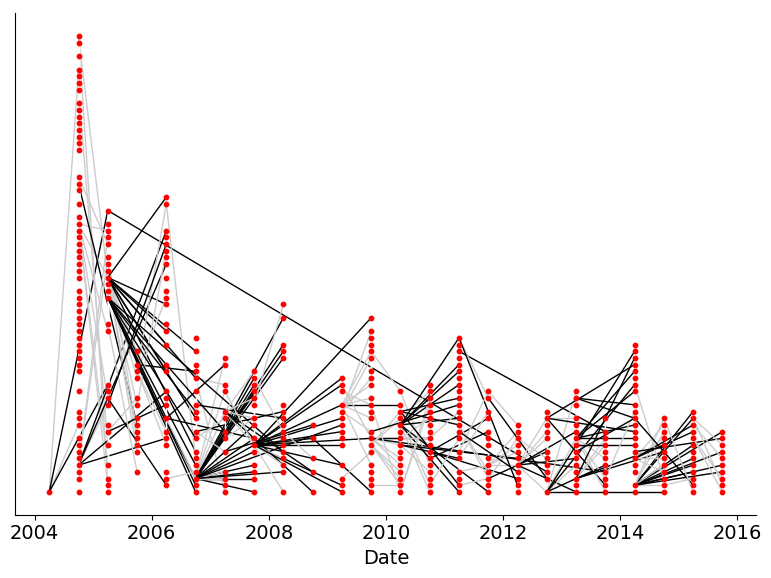

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

nx.draw(
    tree,
    pos=positions,
    ax=ax,
    node_size=10,
    edge_color=edge_colors,
    with_labels=False
)

ax.plot(valid_timepoints, [0.0] * len(valid_timepoints), alpha=0)
ax.set_xlabel("Date")
ax.set_yticks([])
plt.axis("on")
plt.tight_layout()

In [110]:
ax.set_yticks([])

[]

Look for nodes without any edges.

In [111]:
[node for node in tree if len(tree[node]) == 0]

[]

Look for nodes from the last timepoint that connect to nodes from more than one timepoint in the past.

In [112]:
recent_clades = [clade
                 for clade, timepoint in timepoint_by_clade_name.items()
                 if timepoint == df["timepoint"].max()]

In [113]:
recent_clades[:5]

['094e4b9', '2235687', '3c1bdeb', '54e5c99', '56f0c5a']

In [114]:
broken_clade = None
for recent_clade in recent_clades:
    for ancestor in tree[recent_clade]:
        delta = timepoint_by_clade_name[recent_clade] - timepoint_by_clade_name[ancestor]
        if delta.days > 190:
            print(delta)
            
        if delta.days > 370:
            print(recent_clade)
            broken_clade = recent_clade
            break
            
    if broken_clade is not None:
        break

548 days 00:00:00
54e5c99


In [115]:
recent_clade

'54e5c99'

In [116]:
broken_clade = "7d7cafb"

In [117]:
df[df["clade_membership"] == broken_clade].head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [118]:
df[df["tip"] == "A/HongKong/4974/2011"].head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [119]:
tips[tips["strain"] == "A/Okayama/28/2011"]

,strain,clade_membership,timepoint,frequency


In [120]:
df[df["clade_membership"] == broken_clade].shape

(0, 10)

In [121]:
bahia_df = df[(df["tip"] == "A/Bahia/100/2011") & (df["timepoint"] == "2012-04-01")]

In [122]:
bahia_df.head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [123]:
parana_df = df[(df["tip"] == "A/Parana/415/2012") & (df["timepoint"] == "2012-10-01")]

In [124]:
parana_df

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [125]:
tips[tips["strain"] == "A/Bahia/100/2011"]

,strain,clade_membership,timepoint,frequency


In [126]:
tips[tips["strain"] == "A/HoChiMinh/6388/2010"]

,strain,clade_membership,timepoint,frequency


In [127]:
# Identify distinct clades per timepoint.
clades = tips.loc[:, ["timepoint", "clade_membership"]].drop_duplicates().copy()
clades = clades.rename(columns={"timepoint": "initial_timepoint"})

In [128]:
clades[clades["clade_membership"] == "93a23e6"]

,initial_timepoint,clade_membership


In [129]:
df[df["clade_membership"] == "93a23e6"]

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [130]:
clades[clades["initial_timepoint"] == "2012-04-01"].head()

,initial_timepoint,clade_membership
1716,2012-04-01,1de1231
1718,2012-04-01,4fcee9d
1719,2012-04-01,8302ba4
1722,2012-04-01,514e67b
1723,2012-04-01,9371c93


In [131]:
clades[clades["initial_timepoint"] == "2012-10-01"].head()

,initial_timepoint,clade_membership
1863,2012-10-01,1de1231
1865,2012-10-01,4fcee9d
1866,2012-10-01,6625e83
1871,2012-10-01,514e67b
1874,2012-10-01,65b5275


In [132]:
final_clade_frequencies = pd.read_table("../results/builds/h3n2/5_viruses_per_month/sample_0/2000-10-01--2015-10-01/final_clade_frequencies.tsv")

In [133]:
final_clade_frequencies.groupby(["initial_timepoint", "clade_membership"])["frequency"].sum()

initial_timepoint  clade_membership
2004-10-01         00ed6d2             0.000000
                   21b8d11             0.000000
                   482757a             0.000000
                   4ad176b             0.000000
                   57fdf76             0.000000
                   5c72121             0.000000
                   5cbfb7d             0.000000
                   6e5d388             0.000000
                   74907c6             0.000000
                   84dfd90             0.000037
                   8f3fc76             0.000000
                   9415e47             0.000000
                   993737c             0.816643
                   b1c31e8             0.010778
                   d13edda             0.000030
                   d22442e             0.000000
                   d5dbb5e             0.000000
                   dc76926             0.000000
                   e5a7ac4             0.077351
                   e712c33             0.000000
    

In [134]:
clade_counts = final_clade_frequencies.groupby(["initial_timepoint", "clade_membership"])["frequency"].sum().reset_index()

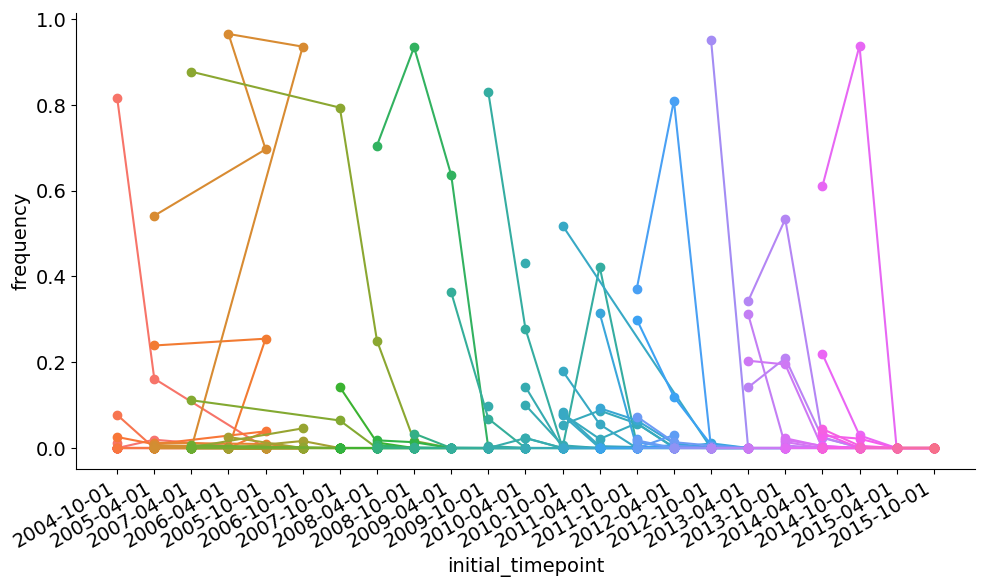

In [135]:
g = sns.FacetGrid(clade_counts, hue="clade_membership", height=6, aspect=1.7)
g.map(plt.plot, "initial_timepoint", "frequency", marker="o")
#g.axes.flatten()[0].set_ylim(0, 1)
plt.gcf().autofmt_xdate()

## Reattempt clade connectivity plots

Build the table of future tips by clade for all distinct clades by timepoint, plot those clades by timepoint, and then plot connections between clades at timepoints where future tip frequencies are non-zero.

In [136]:
delta_months = 12
primary_segment = "ha"
delta_time_offset = pd.DateOffset(months=delta_months)

In [137]:
tips = pd.read_csv("../results/builds/h3n2/5_viruses_per_month/sample_0/2000-10-01--2015-10-01/standardized_tip_attributes.tsv",
                   sep="\t", parse_dates=["timepoint"])
tips = tips.loc[
    tips["segment"] == "ha",
    ["strain", "clade_membership", "timepoint", "frequency"]
].copy()

In [138]:
tips.head()

,strain,clade_membership,timepoint,frequency
0,A/Aichi/181/2004,e5a7ac4,2004-10-01,0.005842
1,A/Aichi/183/2004,e80cc78,2004-10-01,0.005539
2,A/Argentina/126/2004,d22442e,2004-10-01,0.008012
3,A/Argentina/AG-R126-04/2004,d22442e,2004-10-01,0.008012
4,A/Argentina/R26/2004,482757a,2004-10-01,0.004519


In [139]:
tips.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index().sort_values(["timepoint", "frequency"])

,timepoint,clade_membership,frequency
9,2004-10-01,84dfd90,0.000001
6,2004-10-01,5cbfb7d,0.000003
7,2004-10-01,6e5d388,0.000369
0,2004-10-01,00ed6d2,0.000473
11,2004-10-01,9415e47,0.000638
16,2004-10-01,d5dbb5e,0.001388
17,2004-10-01,dc76926,0.001694
19,2004-10-01,e712c33,0.008843
4,2004-10-01,57fdf76,0.013411
12,2004-10-01,993737c,0.013760


In [140]:
# Identify distinct clades per timepoint.
clades = tips.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index().sort_values(["timepoint", "frequency"]).copy()
clades = clades.rename(columns={"timepoint": "initial_timepoint"})
clades = clades.drop(columns="frequency")

In [141]:
# Annotate future timepoint.
clades["final_timepoint"] = clades["initial_timepoint"] + delta_time_offset

In [142]:
clades.head()

,initial_timepoint,clade_membership,final_timepoint
9,2004-10-01,84dfd90,2005-10-01
6,2004-10-01,5cbfb7d,2005-10-01
7,2004-10-01,6e5d388,2005-10-01
0,2004-10-01,00ed6d2,2005-10-01
11,2004-10-01,9415e47,2005-10-01


In [143]:
for timepoint, timepoint_df in clades.groupby("initial_timepoint"):
    clades.loc[clades["initial_timepoint"] == timepoint, "y"] = np.arange(len(timepoint_df))

In [144]:
clades.head(20)

,initial_timepoint,clade_membership,final_timepoint,y
9,2004-10-01,84dfd90,2005-10-01,0.0
6,2004-10-01,5cbfb7d,2005-10-01,1.0
7,2004-10-01,6e5d388,2005-10-01,2.0
0,2004-10-01,00ed6d2,2005-10-01,3.0
11,2004-10-01,9415e47,2005-10-01,4.0
16,2004-10-01,d5dbb5e,2005-10-01,5.0
17,2004-10-01,dc76926,2005-10-01,6.0
19,2004-10-01,e712c33,2005-10-01,7.0
4,2004-10-01,57fdf76,2005-10-01,8.0
12,2004-10-01,993737c,2005-10-01,9.0


In [145]:
# Load mapping of tips to all possible clades at each timepoint.
tips_to_clades = pd.read_csv("../results/builds/h3n2/5_viruses_per_month/sample_0/2000-10-01--2015-10-01/tips_to_clades.tsv", sep="\t", parse_dates=["timepoint"])
tips_to_clades = tips_to_clades.loc[
    tips_to_clades["segment"] == primary_segment,
    ["tip", "clade_membership", "depth", "timepoint"]
].copy()

In [146]:
# Get all tip-clade combinations by timepoint for the distinct clades.
future_tips_by_clades = clades.merge(
    tips_to_clades,
    how="inner",
    left_on=["final_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"]
)

In [147]:
# Drop redundant columns.
future_tips_by_clades = future_tips_by_clades.drop(
    columns=["timepoint"]
)

In [148]:
future_tips_by_clades.head()

,initial_timepoint,clade_membership,final_timepoint,y,tip,depth
0,2004-10-01,84dfd90,2005-10-01,0.0,A/Bangladesh/1164729/2003,1
1,2004-10-01,84dfd90,2005-10-01,0.0,A/Fujian/445/2003,3
2,2004-10-01,84dfd90,2005-10-01,0.0,A/Chita/6/2003,4
3,2004-10-01,84dfd90,2005-10-01,0.0,A/Shanghai/369/2003,4
4,2004-10-01,84dfd90,2005-10-01,0.0,A/HongKong/1173/2003,3


In [149]:
# Get the closest clade to each tip by timepoint. This relies on records
# being sorted by depth of clade from tip.
future_tips_by_clades = future_tips_by_clades.sort_values(["initial_timepoint", "tip", "depth"]).groupby(["initial_timepoint"\
, "tip"]).first().reset_index()

In [150]:
future_tips_by_clades.head()

,initial_timepoint,tip,clade_membership,final_timepoint,y,depth
0,2004-10-01,A/Aichi/181/2004,e5a7ac4,2005-10-01,22.0,1
1,2004-10-01,A/Aichi/183/2004,e80cc78,2005-10-01,13.0,1
2,2004-10-01,A/Anhui/1239/2005,993737c,2005-10-01,9.0,2
3,2004-10-01,A/Anhui/550/2002,84dfd90,2005-10-01,0.0,1
4,2004-10-01,A/Argentina/126/2004,d22442e,2005-10-01,10.0,1


In [151]:
future_tips_by_clades[future_tips_by_clades["tip"] == "A/Aichi/114/2008"]

,initial_timepoint,tip,clade_membership,final_timepoint,y,depth


In [152]:
# Get frequencies of future tips associated with current clades.
future_clade_frequencies = future_tips_by_clades.merge(tips, how="inner", left_on=["tip", "final_timepoint"], right_on=["strain", "timepoint"], suffixes=["", "_tip"])
future_clade_frequencies = future_clade_frequencies.drop(
    columns=[
        "tip",
        "depth",
        "clade_membership_tip",
        "timepoint"
    ]
)

In [153]:
future_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,y,strain,frequency
0,2004-10-01,993737c,2005-10-01,9.0,A/Anhui/1239/2005,0.036938
1,2004-10-01,993737c,2005-10-01,9.0,A/Argentina/AG-R113-05/2005,0.005787
2,2004-10-01,993737c,2005-10-01,9.0,A/Auckland/616/2005,0.000300
3,2004-10-01,993737c,2005-10-01,9.0,A/Australia/NHRC0002/2005,0.000385
4,2004-10-01,993737c,2005-10-01,9.0,A/Australia/NHRC0004/2005,0.000385


In [154]:
future_clade_frequencies.groupby("initial_timepoint")["frequency"].sum()

initial_timepoint
2004-10-01    0.930661
2005-04-01    0.999999
2005-10-01    0.999999
2006-04-01    0.999998
2006-10-01    1.000002
2007-04-01    1.000001
2007-10-01    1.000000
2008-04-01    0.999990
2008-10-01    0.999997
2009-04-01    1.000002
2009-10-01    1.000001
2010-04-01    1.000000
2010-10-01    0.999991
2011-04-01    0.999996
2011-10-01    0.986773
2012-04-01    0.999658
2012-10-01    0.976453
2013-04-01    0.999993
2013-10-01    1.000003
2014-04-01    1.000000
2014-10-01    1.000001
Name: frequency, dtype: float64

(0.9, 1.02)

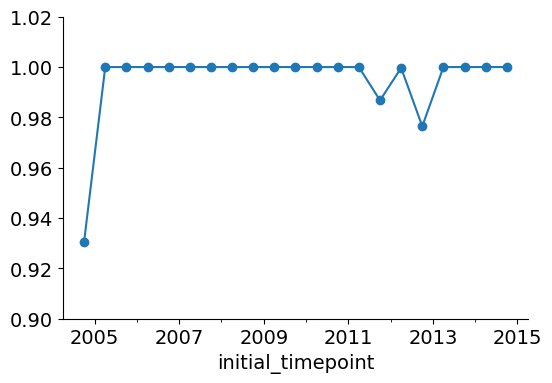

In [155]:
ax = future_clade_frequencies.groupby("initial_timepoint")["frequency"].sum().plot(marker="o")
ax.set_ylim(0.9, 1.02)

In [156]:
future_clades = future_clade_frequencies.loc[:, ["initial_timepoint", "final_timepoint", "clade_membership"]].drop_duplicates()

In [157]:
clades.shape

(698, 4)

In [158]:
clades.head()

,initial_timepoint,clade_membership,final_timepoint,y
9,2004-10-01,84dfd90,2005-10-01,0.0
6,2004-10-01,5cbfb7d,2005-10-01,1.0
7,2004-10-01,6e5d388,2005-10-01,2.0
0,2004-10-01,00ed6d2,2005-10-01,3.0
11,2004-10-01,9415e47,2005-10-01,4.0


In [159]:
future_clades.shape

(160, 3)

In [160]:
future_clades["color"] = "#999999"

In [161]:
future_clades.head()

,initial_timepoint,final_timepoint,clade_membership,color
0,2004-10-01,2005-10-01,993737c,#999999
11,2004-10-01,2005-10-01,e5a7ac4,#999999
29,2004-10-01,2005-10-01,84dfd90,#999999
31,2004-10-01,2005-10-01,ffaf2a6,#999999
70,2004-10-01,2005-10-01,d13edda,#999999


In [162]:
clades.head()

,initial_timepoint,clade_membership,final_timepoint,y
9,2004-10-01,84dfd90,2005-10-01,0.0
6,2004-10-01,5cbfb7d,2005-10-01,1.0
7,2004-10-01,6e5d388,2005-10-01,2.0
0,2004-10-01,00ed6d2,2005-10-01,3.0
11,2004-10-01,9415e47,2005-10-01,4.0


In [163]:
clades.shape

(698, 4)

In [164]:
clades_with_future_clades = clades.merge(future_clades, how="left", on=["initial_timepoint", "final_timepoint", "clade_membership"])

In [165]:
clades_with_future_clades.loc[pd.isnull(clades_with_future_clades["color"]), "color"] = "#cccccc"

In [166]:
clades_with_future_clades.head()

,initial_timepoint,clade_membership,final_timepoint,y,color
0,2004-10-01,84dfd90,2005-10-01,0.0,#999999
1,2004-10-01,5cbfb7d,2005-10-01,1.0,#cccccc
2,2004-10-01,6e5d388,2005-10-01,2.0,#cccccc
3,2004-10-01,00ed6d2,2005-10-01,3.0,#cccccc
4,2004-10-01,9415e47,2005-10-01,4.0,#cccccc


In [167]:
tips[tips["clade_membership"] == "8c6e6c2"]

,strain,clade_membership,timepoint,frequency
1022,A/Kyrgyzstan/WRAIR1256P/2008,8c6e6c2,2009-04-01,0.005490
1053,A/Philippines/3803/2008,8c6e6c2,2009-04-01,0.006157
1145,A/Kyrgyzstan/WRAIR1256P/2008,8c6e6c2,2009-10-01,0.000001


In [168]:
clades_with_future_clades[clades_with_future_clades["color"] == "#cccccc"].shape

(538, 5)

In [169]:
clades_with_future_clades[clades_with_future_clades["color"] == "#cccccc"].merge(tips, left_on=["initial_timepoint", "clade_membership"],
                                                                                 right_on=["timepoint", "clade_membership"]).groupby(
    ["initial_timepoint", "clade_membership"]
)["frequency"].count()

initial_timepoint  clade_membership
2004-10-01         00ed6d2              2
                   21b8d11              1
                   482757a              6
                   4ad176b              2
                   57fdf76              2
                   5c72121              6
                   5cbfb7d              1
                   6e5d388              2
                   74907c6              3
                   8f3fc76             10
                   9415e47              2
                   d22442e              2
                   d5dbb5e              2
                   dc76926              2
                   e712c33              3
                   e80cc78              4
                   f4914df              2
2005-04-01         10c5c60              2
                   2509e22              4
                   2537bbf              2
                   2a92249              1
                   3035805              1
                   482757a              

In [170]:
tips[tips["clade_membership"] == "a54d1ad"]

,strain,clade_membership,timepoint,frequency
1018,A/Kuwait/WRAIR1143P/2009,a54d1ad,2009-04-01,0.005568
1020,A/Kyrgyzstan/WRAIR1121P/2008,a54d1ad,2009-04-01,0.005541
1021,A/Kyrgyzstan/WRAIR1255P/2008,a54d1ad,2009-04-01,0.005490
1034,A/Moscow/402/2009,a54d1ad,2009-04-01,0.005568
1055,A/Qazvin/9/2009,a54d1ad,2009-04-01,0.005589
1141,A/Kuwait/WRAIR1143P/2009,a54d1ad,2009-10-01,0.000166
1143,A/Kyrgyzstan/WRAIR1121P/2008,a54d1ad,2009-10-01,0.000002
1144,A/Kyrgyzstan/WRAIR1255P/2008,a54d1ad,2009-10-01,0.000001
1165,A/Moscow/402/2009,a54d1ad,2009-10-01,0.000166
1194,A/Qazvin/9/2009,a54d1ad,2009-10-01,0.000019


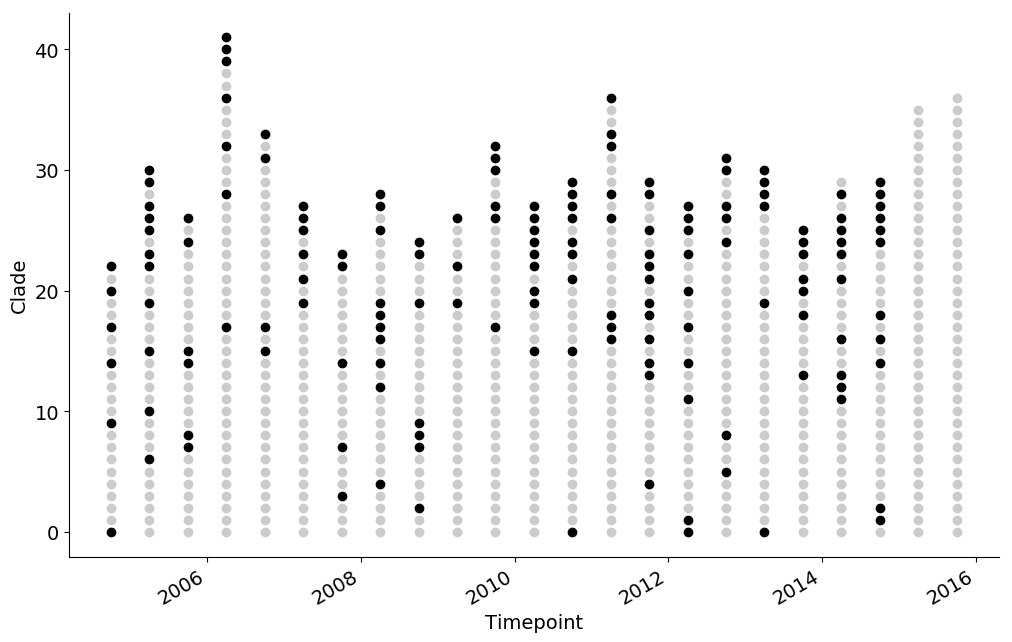

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

present = clades_with_future_clades[clades_with_future_clades["color"] == "#999999"]
ax.plot(present["initial_timepoint"], present["y"], "o", linestyle="", c="#000000")

absent = clades_with_future_clades[clades_with_future_clades["color"] == "#cccccc"]
ax.plot(absent["initial_timepoint"], absent["y"], "o", linestyle="", c="#cccccc")

ax.set_xlabel("Timepoint")
ax.set_ylabel("Clade")
plt.gcf().autofmt_xdate()